In [1]:
# Nativos
import random as rn
import os
import sys
import gc

#calculo
import numpy as np
import pandas as pd
import scipy
from scipy import stats


#grafico
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from IPython.display import display_html
%matplotlib inline
sns.set(style="whitegrid")

#Interacciones con output
import warnings
warnings.filterwarnings("ignore")
# warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

gc.collect()

BASE_DIR = os.path.dirname(os.getcwd())
if BASE_DIR not in sys.path: sys.path.append(BASE_DIR)

#from utils import *
#from graphs import *

SEED = 29082013
os.environ['PYTHONHASHSEED']=str(SEED)
np.random.seed(SEED)
rn.seed(SEED)

#subfolder = "data"
# os.listdir(subfolder)

## >> Utilitarios

In [2]:
def null_verificator(data):        
    if data.isnull().any().any():
        view_info = pd.DataFrame(
            pd.concat(
                [data.isnull().any(), 
                 data.isnull().sum(),
                 data.dtypes], 
                axis=1)
        )
        view_info.columns = ['Nulos', 'Cantidad', 'Tipo Col']
        size = data.shape[0]
        view_info['Porcentaje'] = view_info['Cantidad'].apply(
            lambda x: np.round(0 if not x else x*100 / size, 2))
        return view_info
    else:
        return pd.DataFrame.from_dict({'msje':"DATA LIMPIA DE NULOS"}, orient='index')

In [3]:
def display_horizontal(*args, percent_sep=5):
    html_str=''
    for table in args:
        df = table if isinstance(table, pd.DataFrame) else  pd.DataFrame(table)
        html_str+=df.to_html()
    display_html(
        html_str.replace(
            'table','table style="display:inline;padding-right:{}%"'.format(percent_sep)
        ), 
        raw=True)

In [4]:
def compare_var_train_test(train, test, col_, **kwargs):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
    
    # cantidad
    sns.displot(train[col_], bins=20, ax=axes[0])
    sns.displot(test[col_], bins=20, ax=axes[0])
    
    #densudad
    sns.kdeplot(train[col_], shade=True, ax=axes[1])
    sns.kdeplot(test[col_], shade=True, ax=axes[1])


In [5]:
def compare_var_train_test(train, test, col_, **kwargs):
    fig, axes_ = plt.subplots(nrows=1, ncols=4, figsize=(20, 4))
    
    # cantidad
    sns.histplot(train[col_], bins=20, ax=axes_[0], color='b')
    sns.histplot(test[col_], bins=20, ax=axes_[0], color='r')
    
    #densudad
    sns.kdeplot(train[col_], shade=True, ax=axes_[1], color='b')
    sns.kdeplot(test[col_], shade=True, ax=axes_[1], color='r')
    
    ## cajas
    sns.boxplot(y=train[col], ax=axes_[2], color='b')
    sns.boxplot(y=test[col], ax=axes_[3], color='r')

## >> Descripción de campos

## >> Load data

In [6]:
dicc_load = {
    'engine': 'openpyxl',
    'dtype': {'id': str}
}

In [7]:
train = pd.read_excel('score_train.xlsx',  **dicc_load)
display(train.head())

test = pd.read_excel('score_test.xlsx',  **dicc_load)
display(test.head())

,id,Empleado,Tiempo_empleo,Saldo_cuenta,Valor_prestamo,Cuentas_otros,Autocontrol,Impulsividad,Confianza,Incumplimiento
0,1,0,0,128.133,2895.710,1,45,50,74,0
1,2,1,9,919.644,2781.780,0,38,49,58,0
2,3,1,4,1521.332,4216.502,1,59,54,37,0
3,4,0,0,172.603,1782.369,0,57,58,54,0
4,5,1,9,170.364,3918.458,1,49,37,37,0


,id,Empleado,Tiempo_empleo,Saldo_cuenta,Valor_prestamo,Cuentas_otros,Autocontrol,Impulsividad,Confianza,Incumplimiento
0,6,1,9,285.541,0.000,1,50,61,53,NaN
1,8,1,3,327.126,3226.726,2,47,65,56,NaN
2,9,1,2,287.253,2774.996,1,68,59,63,NaN
3,10,0,0,257.328,2757.177,1,59,49,47,NaN
4,14,1,1,235.422,1923.073,2,66,45,36,NaN


In [8]:
train.shape, test.shape

((63901, 10), (16116, 10))

## >> Análisis de nulos

In [9]:
display_horizontal(
    null_verificator(train), null_verificator(test)
)

0 
 
 
 
 
 msje 
 DATA LIMPIA DE NULOS 
 
 
 
 
 
 
 Nulos 
 Cantidad 
 Tipo Col 
 Porcentaje 
 
 
 
 
 id 
 False 
 0 
 object 
 0.0 
 
 
 Empleado 
 False 
 0 
 int64 
 0.0 
 
 
 Tiempo_empleo 
 False 
 0 
 int64 
 0.0 
 
 
 Saldo_cuenta 
 False 
 0 
 float64 
 0.0 
 
 
 Valor_prestamo 
 False 
 0 
 float64 
 0.0 
 
 
 Cuentas_otros 
 False 
 0 
 int64 
 0.0 
 
 
 Autocontrol 
 False 
 0 
 int64 
 0.0 
 
 
 Impulsividad 
 False 
 0 
 int64 
 0.0 
 
 
 Confianza 
 False 
 0 
 int64 
 0.0 
 
 
 Incumplimiento 
 True 
 16116 
 float64 
 100.0

Conclusión: Data sin nulos

## >> Revisión de Balanceo

In [10]:
train['Incumplimiento'].value_counts(dropna=False, normalize=True)

0    0.858844
1    0.141156
Name: Incumplimiento, dtype: float64

## >> Análisis Descriptivo

#### >>>> Cuantitativos

In [11]:
display_horizontal(
    train.describe().T, test.describe().T
)

,count,mean,std,min,25%,50%,75%,max
Empleado,63901.0,0.850738,0.356349,0.000,1.000,1.000,1.000,1.000
Tiempo_empleo,63901.0,5.097354,4.448149,0.000,2.000,4.000,7.000,48.000
Saldo_cuenta,63901.0,1074.293617,5772.012760,0.046,38.761,147.834,574.988,548592.220
Valor_prestamo,63901.0,2475.226287,1007.259230,-29.788,2169.124,2668.597,3110.260,5307.619
Cuentas_otros,63901.0,1.002942,1.000371,0.000,0.000,1.000,2.000,7.000
Autocontrol,63901.0,49.922114,10.067695,8.000,43.000,50.000,57.000,93.000
Impulsividad,63901.0,49.965791,10.026528,12.000,43.000,50.000,57.000,92.000
Confianza,63901.0,49.981064,10.010524,8.000,43.000,50.000,57.000,94.000
Incumplimiento,63901.0,0.141156,0.348185,0.000,0.000,0.000,0.000,1.000
,count,mean,std,min,25%,50%,75%,max


### >> Correcion de valor_prestamo negativos

In [12]:
train['Valor_prestamo'] = train['Valor_prestamo'].apply(lambda _: 0 if _ < 0 else _)
test['Valor_prestamo'] = test['Valor_prestamo'].apply(lambda _: 0 if _ < 0 else _)

In [13]:
cols_num = [col for col in train.describe().columns if set(train[col]) != {0, 1}]
print(cols_num)

['Tiempo_empleo', 'Saldo_cuenta', 'Valor_prestamo', 'Cuentas_otros', 'Autocontrol', 'Impulsividad', 'Confianza']


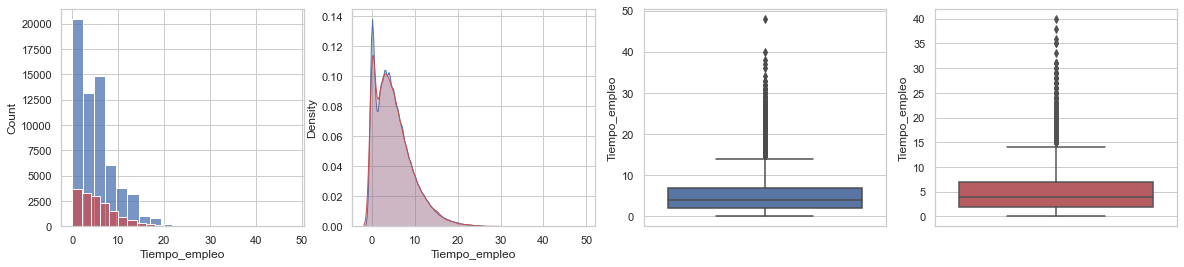

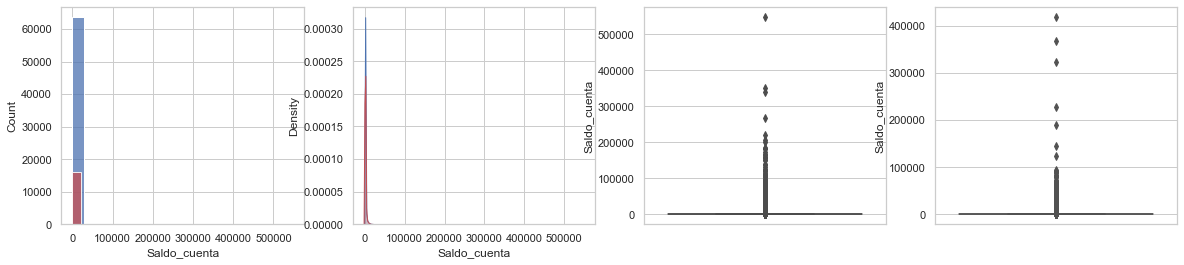

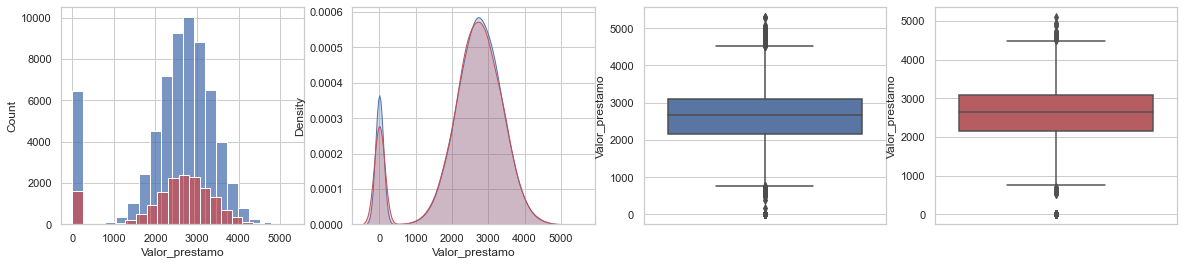

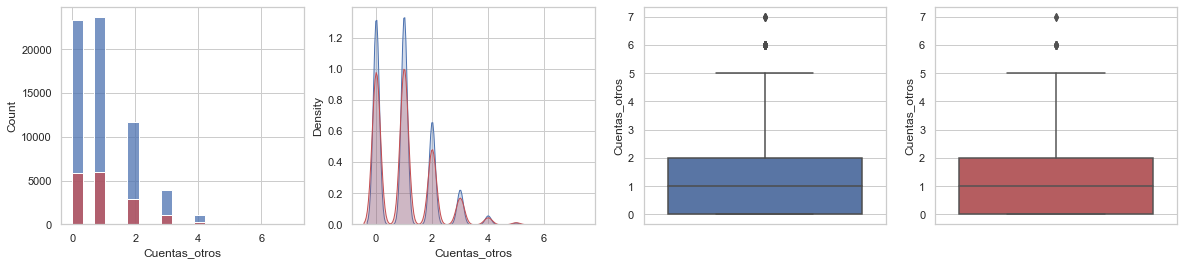

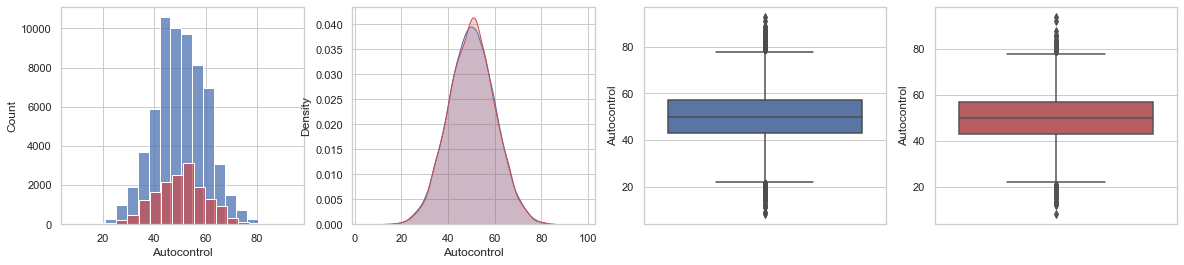

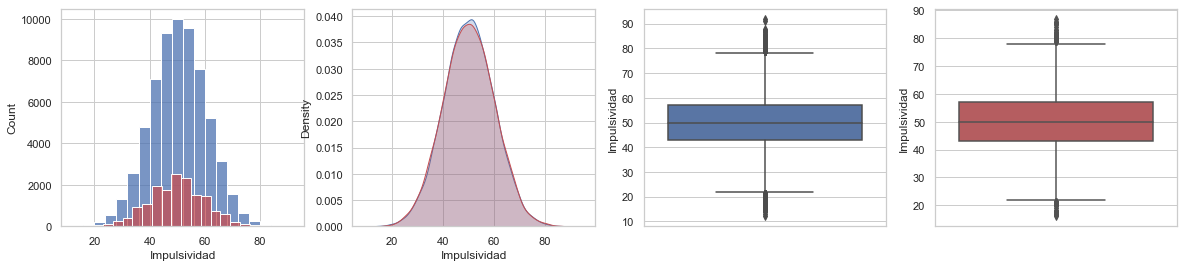

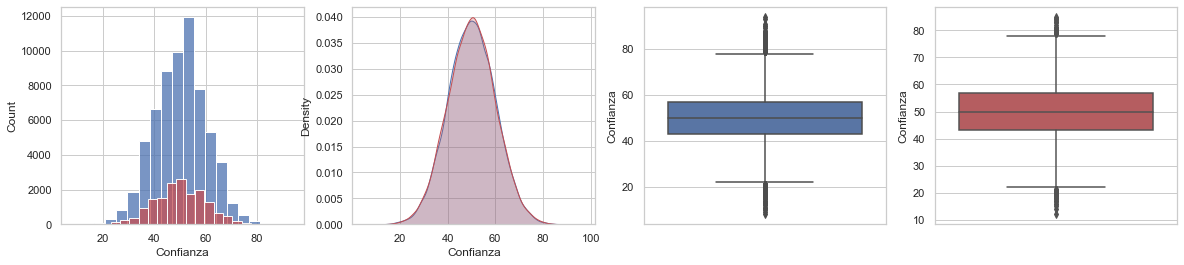

In [14]:
for col in cols_num:
    compare_var_train_test(train, test, col)

#### >>>> Cualitativos

In [15]:
display_horizontal(
    train.describe(include=[bool, object]).T, test.describe(include=[bool, object]).T
)

,count,unique,top,freq
id,63901,63901,68410,1
,count,unique,top,freq
id,16116,16116,2789,1


## >> Gráfico QQplot

////////////////////////////////////////////////// Tiempo_empleo


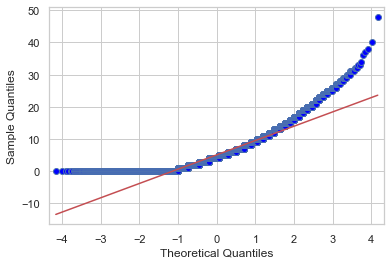

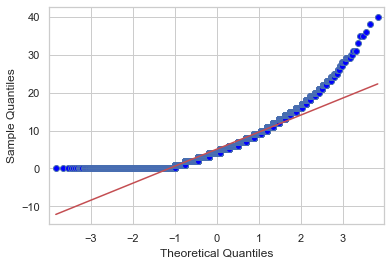

////////////////////////////////////////////////////////////////////////////////////////////////////
////////////////////////////////////////////////// Saldo_cuenta


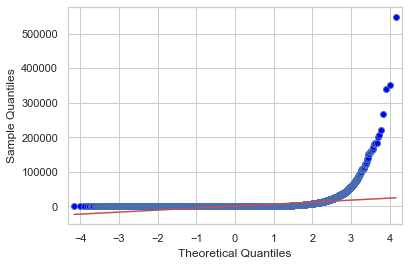

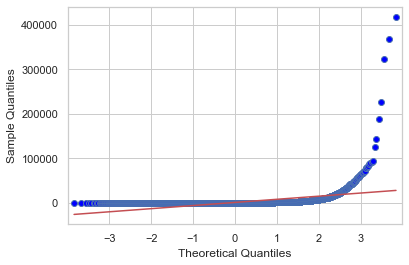

////////////////////////////////////////////////////////////////////////////////////////////////////
////////////////////////////////////////////////// Valor_prestamo


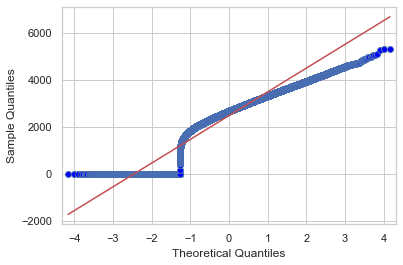

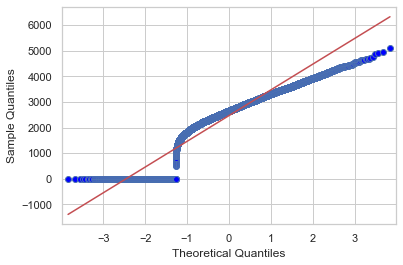

////////////////////////////////////////////////////////////////////////////////////////////////////
////////////////////////////////////////////////// Cuentas_otros


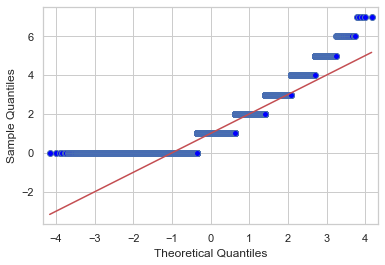

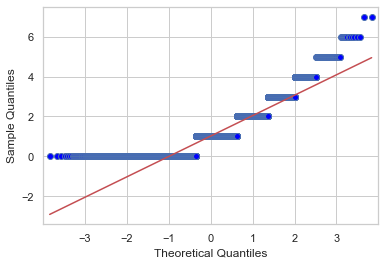

////////////////////////////////////////////////////////////////////////////////////////////////////
////////////////////////////////////////////////// Autocontrol


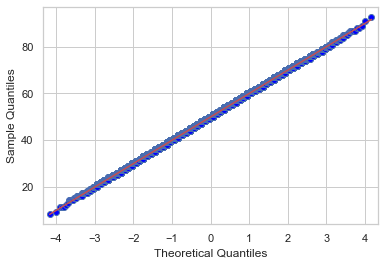

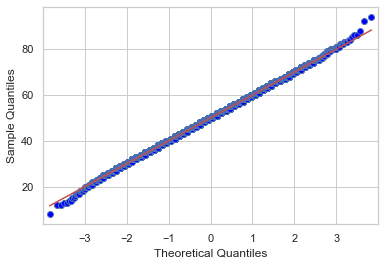

////////////////////////////////////////////////////////////////////////////////////////////////////
////////////////////////////////////////////////// Impulsividad


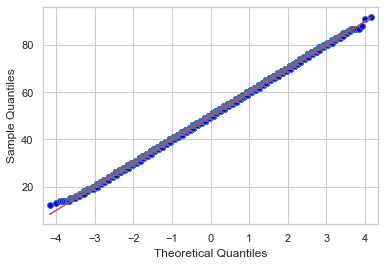

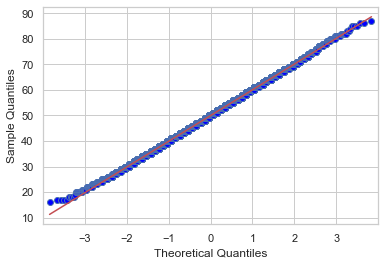

////////////////////////////////////////////////////////////////////////////////////////////////////
////////////////////////////////////////////////// Confianza


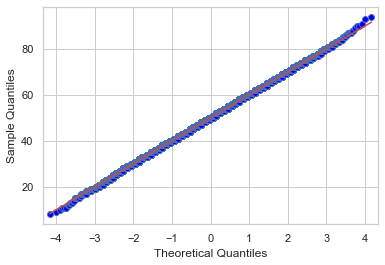

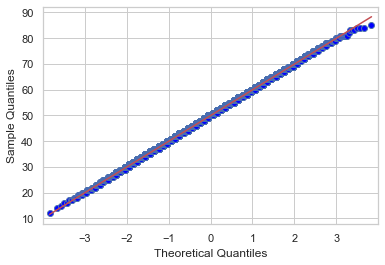

////////////////////////////////////////////////////////////////////////////////////////////////////


In [16]:
from statsmodels.graphics.gofplots import qqplot

for col in cols_num:
    print("/"*50, col)
    fig = qqplot(train[col] , line='s')
    fig2 = qqplot(test[col] , line='s')
    plt.show()
    print("/"*100)

## >> Pruebas de Normalidad

In [17]:
def test_normalidad(data, col, method='kolmogorov', alpha=0.05, tipo='train'):
    metodos_validos = ['shapiro', 'kolmogorov', 'agostino']
    
    if method not in metodos_validos:
        return 'Ingrese un método válido'
    
    if method == 'shapiro':
        stat, p = stats.shapiro(data[col])
    elif method == 'kolmogorov':
        ks = stats.kstest(data[col], 'norm')
        p = ks.pvalue
        stat = ks.statistic
    elif method == 'agostino':
        stat, p = stats.normaltest(data[col])
    
    if p > alpha:
        msg = 'NORMALIDAD - No hay evidencia para rechzar la hipotesis nula'
    else:
        msg = 'NO GAUSSIANO - Se rechaza la hipotesis nula - NO NORMAL'
    
    return pd.DataFrame({
        'Nombre de variable':  col,
        'Tipo de data': tipo,
        'Tamaño de la muestra': 'train: {}, test: {} '.format(train.shape[0], test.shape[0]),
        'valor del estadístico': stat,
        'p-valor': p,
        'Resultado': msg
    }, index=[0])

#### >>>> Shapiro 

In [18]:
pd.concat( 
    [test_normalidad(train, col, method='shapiro', tipo='train') for col in cols_num] + [test_normalidad(test, col, method='shapiro', tipo='test') for col in cols_num] , axis=0, ignore_index=True
).sort_values(by=['Nombre de variable'], ascending=False)

,Nombre de variable,Tipo de data,Tamaño de la muestra,valor del estadístico,p-valor,Resultado
2,Valor_prestamo,train,"train: 63901, test: 16116",0.868228,0.000000e+00,NO GAUSSIANO - Se rechaza la hipotesis nula - ...
9,Valor_prestamo,test,"train: 63901, test: 16116",0.869136,0.000000e+00,NO GAUSSIANO - Se rechaza la hipotesis nula - ...
0,Tiempo_empleo,train,"train: 63901, test: 16116",0.898591,0.000000e+00,NO GAUSSIANO - Se rechaza la hipotesis nula - ...
7,Tiempo_empleo,test,"train: 63901, test: 16116",0.893868,0.000000e+00,NO GAUSSIANO - Se rechaza la hipotesis nula - ...
1,Saldo_cuenta,train,"train: 63901, test: 16116",0.131857,0.000000e+00,NO GAUSSIANO - Se rechaza la hipotesis nula - ...
8,Saldo_cuenta,test,"train: 63901, test: 16116",0.100939,0.000000e+00,NO GAUSSIANO - Se rechaza la hipotesis nula - ...
5,Impulsividad,train,"train: 63901, test: 16116",0.999322,2.216399e-14,NO GAUSSIANO - Se rechaza la hipotesis nula - ...
12,Impulsividad,test,"train: 63901, test: 16116",0.998960,1.379161e-08,NO GAUSSIANO - Se rechaza la hipotesis nula - ...
3,Cuentas_otros,train,"train: 63901, test: 16116",0.833501,0.000000e+00,NO GAUSSIANO - Se rechaza la hipotesis nula - ...
10,Cuentas_otros,test,"train: 63901, test: 16116",0.830989,0.000000e+00,NO GAUSSIANO - Se rechaza la hipotesis nula - ...


#### >>>>  Kolmogorov Smirnov

In [19]:
pd.concat( 
    [test_normalidad(train, col, method='kolmogorov', tipo='train') for col in cols_num] + [test_normalidad(test, col, method='kolmogorov', tipo='test') for col in cols_num] , axis=0, ignore_index=True
).sort_values(by=['Nombre de variable'], ascending=False)

,Nombre de variable,Tipo de data,Tamaño de la muestra,valor del estadístico,p-valor,Resultado
2,Valor_prestamo,train,"train: 63901, test: 16116",0.899188,0.0,NO GAUSSIANO - Se rechaza la hipotesis nula - ...
9,Valor_prestamo,test,"train: 63901, test: 16116",0.898858,0.0,NO GAUSSIANO - Se rechaza la hipotesis nula - ...
0,Tiempo_empleo,train,"train: 63901, test: 16116",0.751651,0.0,NO GAUSSIANO - Se rechaza la hipotesis nula - ...
7,Tiempo_empleo,test,"train: 63901, test: 16116",0.750208,0.0,NO GAUSSIANO - Se rechaza la hipotesis nula - ...
1,Saldo_cuenta,train,"train: 63901, test: 16116",0.974890,0.0,NO GAUSSIANO - Se rechaza la hipotesis nula - ...
8,Saldo_cuenta,test,"train: 63901, test: 16116",0.975354,0.0,NO GAUSSIANO - Se rechaza la hipotesis nula - ...
5,Impulsividad,train,"train: 63901, test: 16116",1.000000,0.0,NO GAUSSIANO - Se rechaza la hipotesis nula - ...
12,Impulsividad,test,"train: 63901, test: 16116",1.000000,0.0,NO GAUSSIANO - Se rechaza la hipotesis nula - ...
3,Cuentas_otros,train,"train: 63901, test: 16116",0.500000,0.0,NO GAUSSIANO - Se rechaza la hipotesis nula - ...
10,Cuentas_otros,test,"train: 63901, test: 16116",0.500000,0.0,NO GAUSSIANO - Se rechaza la hipotesis nula - ...


#### >>>> Agostino

In [20]:
pd.concat( 
    [test_normalidad(train, col, method='agostino', tipo='train') for col in cols_num] + [test_normalidad(test, col, method='agostino', tipo='test') for col in cols_num] , axis=0, ignore_index=True
).sort_values(by=['Nombre de variable'], ascending=False)

,Nombre de variable,Tipo de data,Tamaño de la muestra,valor del estadístico,p-valor,Resultado
2,Valor_prestamo,train,"train: 63901, test: 16116",11516.150657,0.000000,NO GAUSSIANO - Se rechaza la hipotesis nula - ...
9,Valor_prestamo,test,"train: 63901, test: 16116",2879.088899,0.000000,NO GAUSSIANO - Se rechaza la hipotesis nula - ...
0,Tiempo_empleo,train,"train: 63901, test: 16116",14263.131960,0.000000,NO GAUSSIANO - Se rechaza la hipotesis nula - ...
7,Tiempo_empleo,test,"train: 63901, test: 16116",3991.001669,0.000000,NO GAUSSIANO - Se rechaza la hipotesis nula - ...
1,Saldo_cuenta,train,"train: 63901, test: 16116",172665.053320,0.000000,NO GAUSSIANO - Se rechaza la hipotesis nula - ...
8,Saldo_cuenta,test,"train: 63901, test: 16116",44020.376613,0.000000,NO GAUSSIANO - Se rechaza la hipotesis nula - ...
5,Impulsividad,train,"train: 63901, test: 16116",1.173941,0.556009,NORMALIDAD - No hay evidencia para rechzar la ...
12,Impulsividad,test,"train: 63901, test: 16116",5.529088,0.063005,NORMALIDAD - No hay evidencia para rechzar la ...
3,Cuentas_otros,train,"train: 63901, test: 16116",8751.021816,0.000000,NO GAUSSIANO - Se rechaza la hipotesis nula - ...
10,Cuentas_otros,test,"train: 63901, test: 16116",2586.984968,0.000000,NO GAUSSIANO - Se rechaza la hipotesis nula - ...


## >> Pruebas de Homocedasticidad

In [21]:
def test_homocedasticidad(train, test, col, method='bartlett', alpha=0.05):
    metodos_validos = ['levene', 'bartlett', 'fligner']
    
    if method not in metodos_validos:
        return 'Ingrese un método válido'
    
    if method == 'levene':
        prueba = stats.levene(train[col], test[col], center='median')
    elif method == 'bartlett':
        prueba = stats.bartlett(train[col], test[col])
    elif method == 'fligner':
        prueba = stats.fligner(train[col], test[col], center='median')

    p = prueba.pvalue
    stat = prueba.statistic
    
    if p > alpha:
        msg = 'HOMOCEDASTICIDAD - No hay evidencia para rechzar la hipotesis nula'
    else:
        msg = 'HETEROCEDASTICIDAD - Se rechaza la hipotesis nula - NO NORMAL'
    
    return pd.DataFrame({
        'Nombre de variable':  col,
        'Tamaño de la muestra': 'train: {}, test: {} '.format(train.shape[0], test.shape[0]),
        'valor del estadístico': stat,
        'p-valor': p,
        'Resultado': msg
    }, index=[0])

#### >>>> Barlett

In [22]:
pd.concat( 
    [test_homocedasticidad(train, test, col, method='bartlett') for col in cols_num], axis=0, ignore_index=True
)

,Nombre de variable,Tamaño de la muestra,valor del estadístico,p-valor,Resultado
0,Tiempo_empleo,"train: 63901, test: 16116",1.612310,2.041674e-01,HOMOCEDASTICIDAD - No hay evidencia para rechz...
1,Saldo_cuenta,"train: 63901, test: 16116",1082.685713,1.914578e-237,HETEROCEDASTICIDAD - Se rechaza la hipotesis n...
2,Valor_prestamo,"train: 63901, test: 16116",0.083277,7.729043e-01,HOMOCEDASTICIDAD - No hay evidencia para rechz...
3,Cuentas_otros,"train: 63901, test: 16116",13.974997,1.852579e-04,HETEROCEDASTICIDAD - Se rechaza la hipotesis n...
4,Autocontrol,"train: 63901, test: 16116",2.544819,1.106566e-01,HOMOCEDASTICIDAD - No hay evidencia para rechz...
5,Impulsividad,"train: 63901, test: 16116",0.724656,3.946208e-01,HOMOCEDASTICIDAD - No hay evidencia para rechz...
6,Confianza,"train: 63901, test: 16116",0.019911,8.877864e-01,HOMOCEDASTICIDAD - No hay evidencia para rechz...


#### >>>> Levene

In [23]:
pd.concat( 
    [test_homocedasticidad(train, test, col, method='levene') for col in cols_num], axis=0, ignore_index=True
)

,Nombre de variable,Tamaño de la muestra,valor del estadístico,p-valor,Resultado
0,Tiempo_empleo,"train: 63901, test: 16116",0.234873,0.627935,HOMOCEDASTICIDAD - No hay evidencia para rechz...
1,Saldo_cuenta,"train: 63901, test: 16116",0.327388,0.567203,HOMOCEDASTICIDAD - No hay evidencia para rechz...
2,Valor_prestamo,"train: 63901, test: 16116",0.002325,0.961541,HOMOCEDASTICIDAD - No hay evidencia para rechz...
3,Cuentas_otros,"train: 63901, test: 16116",2.197305,0.138256,HOMOCEDASTICIDAD - No hay evidencia para rechz...
4,Autocontrol,"train: 63901, test: 16116",4.549158,0.032938,HETEROCEDASTICIDAD - Se rechaza la hipotesis n...
5,Impulsividad,"train: 63901, test: 16116",1.623600,0.202594,HOMOCEDASTICIDAD - No hay evidencia para rechz...
6,Confianza,"train: 63901, test: 16116",0.094557,0.758463,HOMOCEDASTICIDAD - No hay evidencia para rechz...


#### >>>> Fligner

In [24]:
pd.concat( 
    [test_homocedasticidad(train, test, col, method='fligner') for col in cols_num], axis=0, ignore_index=True
)

,Nombre de variable,Tamaño de la muestra,valor del estadístico,p-valor,Resultado
0,Tiempo_empleo,"train: 63901, test: 16116",0.151197,6.973942e-01,HOMOCEDASTICIDAD - No hay evidencia para rechz...
1,Saldo_cuenta,"train: 63901, test: 16116",12.787828,3.488820e-04,HETEROCEDASTICIDAD - Se rechaza la hipotesis n...
2,Valor_prestamo,"train: 63901, test: 16116",47.765487,4.803746e-12,HETEROCEDASTICIDAD - Se rechaza la hipotesis n...
3,Cuentas_otros,"train: 63901, test: 16116",2.266147,1.322283e-01,HOMOCEDASTICIDAD - No hay evidencia para rechz...
4,Autocontrol,"train: 63901, test: 16116",4.565989,3.261284e-02,HETEROCEDASTICIDAD - Se rechaza la hipotesis n...
5,Impulsividad,"train: 63901, test: 16116",1.614713,2.038306e-01,HOMOCEDASTICIDAD - No hay evidencia para rechz...
6,Confianza,"train: 63901, test: 16116",0.089894,7.643121e-01,HOMOCEDASTICIDAD - No hay evidencia para rechz...


## >> Analisis de Correlación

In [25]:
train.corr(method='spearman').style.background_gradient(
    cmap='coolwarm', axis=None
).set_precision(3)

,Empleado,Tiempo_empleo,Saldo_cuenta,Valor_prestamo,Cuentas_otros,Autocontrol,Impulsividad,Confianza,Incumplimiento
Empleado,1.000,0.613,0.001,-0.003,0.003,0.006,-0.004,0.001,0.001
Tiempo_empleo,0.613,1.000,0.000,0.002,-0.001,0.003,-0.004,0.003,0.002
Saldo_cuenta,0.001,0.000,1.000,0.004,0.001,-0.002,0.001,-0.005,-0.005
Valor_prestamo,-0.003,0.002,0.004,1.000,-0.002,0.007,-0.005,0.000,-0.004
Cuentas_otros,0.003,-0.001,0.001,-0.002,1.000,-0.000,0.003,0.002,0.005
Autocontrol,0.006,0.003,-0.002,0.007,-0.000,1.000,0.002,0.004,-0.004
Impulsividad,-0.004,-0.004,0.001,-0.005,0.003,0.002,1.000,-0.004,-0.004
Confianza,0.001,0.003,-0.005,0.000,0.002,0.004,-0.004,1.000,-0.002
Incumplimiento,0.001,0.002,-0.005,-0.004,0.005,-0.004,-0.004,-0.002,1.000


In [26]:
test.corr(method='spearman').style.background_gradient(
    cmap='coolwarm', axis=None
).set_precision(3)

,Empleado,Tiempo_empleo,Saldo_cuenta,Valor_prestamo,Cuentas_otros,Autocontrol,Impulsividad,Confianza,Incumplimiento
Empleado,1.000,0.612,0.000,0.006,0.011,0.001,-0.001,0.013,nan
Tiempo_empleo,0.612,1.000,0.010,-0.001,0.008,-0.000,-0.001,0.017,nan
Saldo_cuenta,0.000,0.010,1.000,0.003,0.014,-0.006,0.013,0.014,nan
Valor_prestamo,0.006,-0.001,0.003,1.000,0.014,0.000,-0.002,-0.010,nan
Cuentas_otros,0.011,0.008,0.014,0.014,1.000,0.005,0.013,-0.008,nan
Autocontrol,0.001,-0.000,-0.006,0.000,0.005,1.000,0.015,0.002,nan
Impulsividad,-0.001,-0.001,0.013,-0.002,0.013,0.015,1.000,-0.011,nan
Confianza,0.013,0.017,0.014,-0.010,-0.008,0.002,-0.011,1.000,nan
Incumplimiento,nan,nan,nan,nan,nan,nan,nan,nan,nan


## >> Inspección de Gráicos Bivariado

In [27]:
def graph_numeric(data, col_init, col_out, **kwargs):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
    
    sns.lineplot(x=col_init, y=col_out, data=data, ax=axes[0])
    sns.violinplot(x=col_init, y=col_out, data=data, ax=axes[1], orient='h')
    
    legend_list = []
    
    for opt in data[col_out].unique():
        sns.kdeplot(data[data[col_out] == opt][col_init], ax=axes[2], shade=True)
        legend_list.append(opt)
    plt.legend(legend_list)

In [28]:
def graph_categoryc(data, col_init, col_out, **kwargs):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
    
    cp = sns.countplot(x=col_init, hue=col_out, data=data, ax=axes[0])
    plt.setp(cp.get_xticklabels(), rotation=90)
    
    cross = pd.crosstab(data[col_out], data[col_init])
    sum_total = sum([cross[col].sum() for col in cross.columns])
    sns.heatmap(
        cross/sum_total, 
        annot=True, ax=axes[1], center=0, cmap="YlGnBu", fmt='.0%'
    )
    bp = sns.barplot(
        x=col_init, y=col_out, data=data, ax=axes[2]
    )
    
    plt.setp(bp.get_xticklabels(), rotation=90)

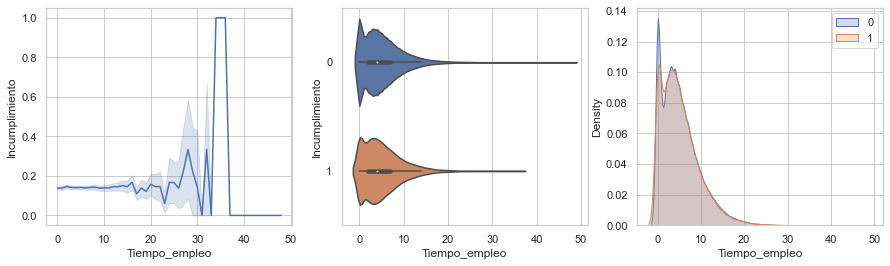

In [29]:
graph_numeric(train, 'Tiempo_empleo', 'Incumplimiento')

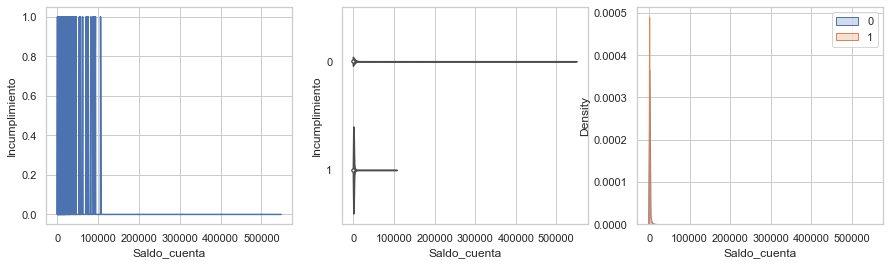

In [30]:
graph_numeric(train, 'Saldo_cuenta', 'Incumplimiento')

In [31]:
train['Saldo_cuenta_menor_10000'] = train['Saldo_cuenta'].apply(lambda _: _ < 10000).astype(int)
test['Saldo_cuenta_menor_10000'] = test['Saldo_cuenta'].apply(lambda _: _ < 10000).astype(int)

pd.crosstab(
    train['Saldo_cuenta_menor_10000'], train['Incumplimiento']
)

Incumplimiento,0,1
Saldo_cuenta_menor_10000,,
0,967,166
1,53914,8854


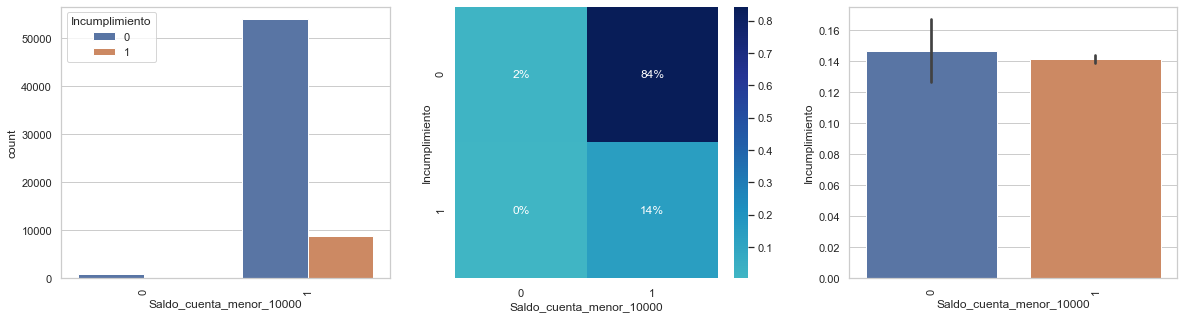

In [32]:
graph_categoryc(train, 'Saldo_cuenta_menor_10000', 'Incumplimiento')

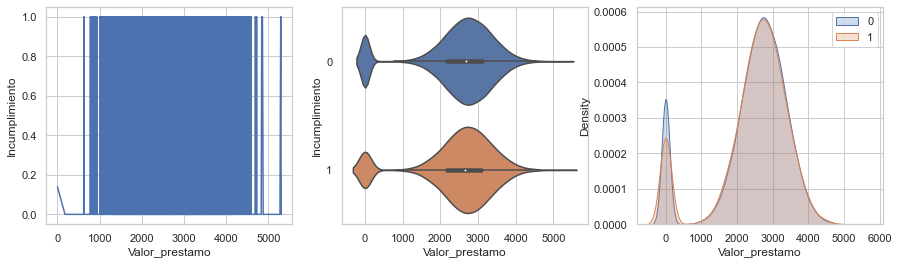

In [33]:
graph_numeric(train, 'Valor_prestamo', 'Incumplimiento')

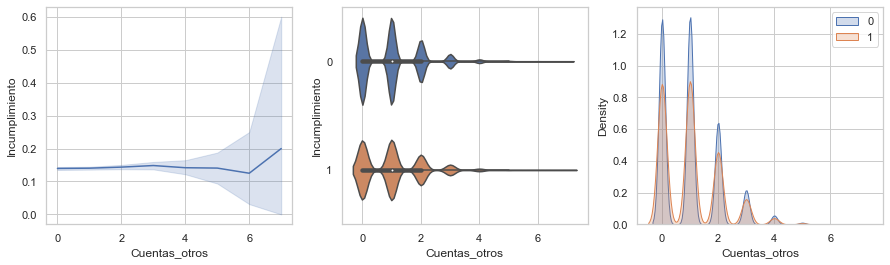

In [34]:
graph_numeric(train, 'Cuentas_otros', 'Incumplimiento')

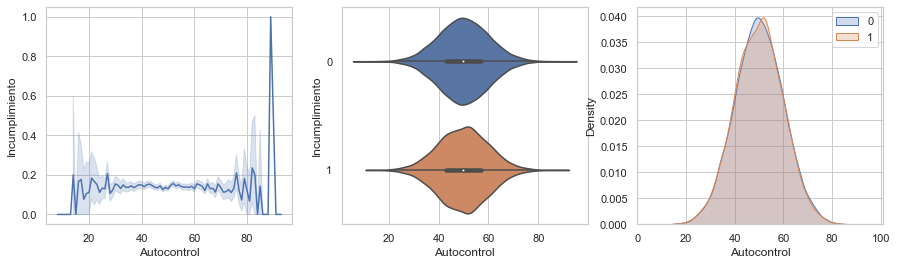

In [35]:
graph_numeric(train, 'Autocontrol', 'Incumplimiento')

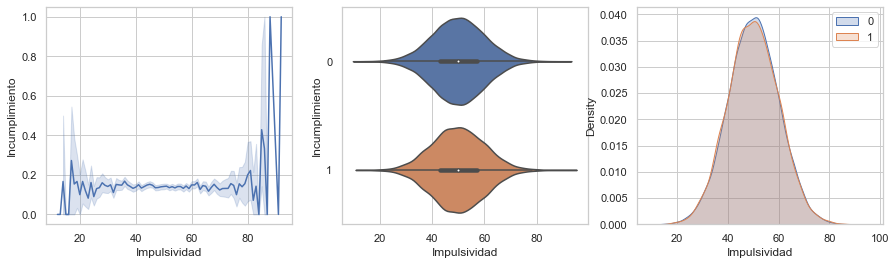

In [36]:
graph_numeric(train, 'Impulsividad', 'Incumplimiento')

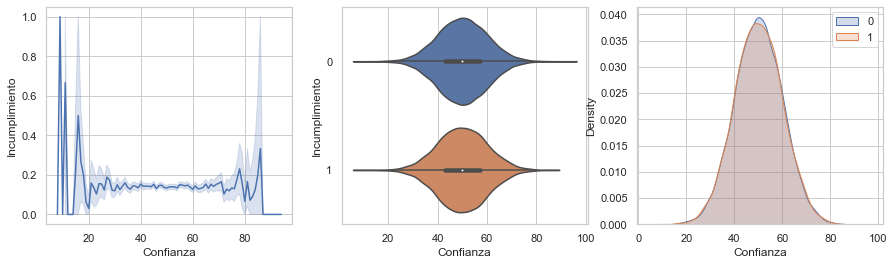

In [37]:
graph_numeric(train, 'Confianza', 'Incumplimiento')

In [39]:
import itertools

def div_simple(x, y):
    if x == 0 and y == 0:
        return 0
    elif y == 0:
        return 1.01
    
    return x / y

for a, b in list(itertools.combinations(['Cuentas_otros', 'Valor_prestamo', 'Saldo_cuenta', 'Tiempo_empleo'] + ['Autocontrol', 'Impulsividad', 'Confianza'], 2)):
    new_col = '{}_x_{}'.format(a, b).lower()
    
    train[new_col] = train[[a, b]].apply(lambda _: _[0]*_[1], axis=1)
    test[new_col] = test[[a, b]].apply(lambda _: _[0]*_[1], axis=1)
    print(new_col)
    
    if 'cuentas_otros' not in new_col:
        other_nwe = new_col  + '_entre_cuentas_otros'
        train[other_nwe] = train[[new_col, 'Cuentas_otros']].apply(lambda _: div_simple(_[0], _[1]), axis=1)
        test[other_nwe] = test[[new_col, 'Cuentas_otros']].apply(lambda _: div_simple(_[0], _[1]), axis=1)
        #graph_numeric(train, other_nwe, 'Incumplimiento')
        print(other_nwe)
        
    if 'tiempo_empleo' not in new_col:
        other_nwe = new_col  + '_entre_tiempo_empleo'
        train[other_nwe] = train[[new_col, 'Tiempo_empleo']].apply(lambda _: div_simple(_[0], _[1]), axis=1)
        test[other_nwe] = test[[new_col, 'Tiempo_empleo']].apply(lambda _: div_simple(_[0], _[1]), axis=1)
        #graph_numeric(train, other_nwe, 'Incumplimiento')
        print(other_nwe)

cuentas_otros_x_valor_prestamo
cuentas_otros_x_valor_prestamo_entre_tiempo_empleo
cuentas_otros_x_saldo_cuenta
cuentas_otros_x_saldo_cuenta_entre_tiempo_empleo
cuentas_otros_x_tiempo_empleo
cuentas_otros_x_autocontrol
cuentas_otros_x_autocontrol_entre_tiempo_empleo
cuentas_otros_x_impulsividad
cuentas_otros_x_impulsividad_entre_tiempo_empleo
cuentas_otros_x_confianza
cuentas_otros_x_confianza_entre_tiempo_empleo
valor_prestamo_x_saldo_cuenta
valor_prestamo_x_saldo_cuenta_entre_cuentas_otros
valor_prestamo_x_saldo_cuenta_entre_tiempo_empleo
valor_prestamo_x_tiempo_empleo
valor_prestamo_x_tiempo_empleo_entre_cuentas_otros
valor_prestamo_x_autocontrol
valor_prestamo_x_autocontrol_entre_cuentas_otros
valor_prestamo_x_autocontrol_entre_tiempo_empleo
valor_prestamo_x_impulsividad
valor_prestamo_x_impulsividad_entre_cuentas_otros
valor_prestamo_x_impulsividad_entre_tiempo_empleo
valor_prestamo_x_confianza
valor_prestamo_x_confianza_entre_cuentas_otros
valor_prestamo_x_confianza_entre_tiempo_e

In [40]:
view_graph = False

In [41]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Empleado,63901.0,8.507379e-01,3.563495e-01,0.000000,1.000000,1.000000,1.000000e+00,1.000000e+00
Tiempo_empleo,63901.0,5.097354e+00,4.448149e+00,0.000000,2.000000,4.000000,7.000000e+00,4.800000e+01
Saldo_cuenta,63901.0,1.074294e+03,5.772013e+03,0.046000,38.761000,147.834000,5.749880e+02,5.485922e+05
Valor_prestamo,63901.0,2.475227e+03,1.007258e+03,0.000000,2169.124000,2668.597000,3.110260e+03,5.307619e+03
Cuentas_otros,63901.0,1.002942e+00,1.000371e+00,0.000000,0.000000,1.000000,2.000000e+00,7.000000e+00
Autocontrol,63901.0,4.992211e+01,1.006770e+01,8.000000,43.000000,50.000000,5.700000e+01,9.300000e+01
Impulsividad,63901.0,4.996579e+01,1.002653e+01,12.000000,43.000000,50.000000,5.700000e+01,9.200000e+01
Confianza,63901.0,4.998106e+01,1.001052e+01,8.000000,43.000000,50.000000,5.700000e+01,9.400000e+01
Incumplimiento,63901.0,1.411559e-01,3.481850e-01,0.000000,0.000000,0.000000,0.000000e+00,1.000000e+00
Saldo_cuenta_menor_10000,63901.0,9.822694e-01,1.319714e-01,0.000000,1.000000,1.000000,1.000000e+00,1.000000e+00


## Nuevamente correlacion

In [42]:
matriz_corr = train.corr(method='spearman')

matriz_corr.style.background_gradient(
    cmap='coolwarm', axis=None
).set_precision(5)

,Empleado,Tiempo_empleo,Saldo_cuenta,Valor_prestamo,Cuentas_otros,Autocontrol,Impulsividad,Confianza,Incumplimiento,Saldo_cuenta_menor_10000,cuentas_otros_x_valor_prestamo,cuentas_otros_x_valor_prestamo_entre_tiempo_empleo,cuentas_otros_x_saldo_cuenta,cuentas_otros_x_saldo_cuenta_entre_tiempo_empleo,cuentas_otros_x_tiempo_empleo,cuentas_otros_x_autocontrol,cuentas_otros_x_autocontrol_entre_tiempo_empleo,cuentas_otros_x_impulsividad,cuentas_otros_x_impulsividad_entre_tiempo_empleo,cuentas_otros_x_confianza,cuentas_otros_x_confianza_entre_tiempo_empleo,valor_prestamo_x_saldo_cuenta,valor_prestamo_x_saldo_cuenta_entre_cuentas_otros,valor_prestamo_x_saldo_cuenta_entre_tiempo_empleo,valor_prestamo_x_tiempo_empleo,valor_prestamo_x_tiempo_empleo_entre_cuentas_otros,valor_prestamo_x_autocontrol,valor_prestamo_x_autocontrol_entre_cuentas_otros,valor_prestamo_x_autocontrol_entre_tiempo_empleo,valor_prestamo_x_impulsividad,valor_prestamo_x_impulsividad_entre_cuentas_otros,valor_prestamo_x_impulsividad_entre_tiempo_empleo,valor_prestamo_x_confianza,valor_prestamo_x_confianza_entre_cuentas_otros,valor_prestamo_x_confianza_entre_tiempo_empleo,saldo_cuenta_x_tiempo_empleo,saldo_cuenta_x_tiempo_empleo_entre_cuentas_otros,saldo_cuenta_x_autocontrol,saldo_cuenta_x_autocontrol_entre_cuentas_otros,saldo_cuenta_x_autocontrol_entre_tiempo_empleo,saldo_cuenta_x_impulsividad,saldo_cuenta_x_impulsividad_entre_cuentas_otros,saldo_cuenta_x_impulsividad_entre_tiempo_empleo,saldo_cuenta_x_confianza,saldo_cuenta_x_confianza_entre_cuentas_otros,saldo_cuenta_x_confianza_entre_tiempo_empleo,tiempo_empleo_x_autocontrol,tiempo_empleo_x_autocontrol_entre_cuentas_otros,tiempo_empleo_x_impulsividad,tiempo_empleo_x_impulsividad_entre_cuentas_otros,tiempo_empleo_x_confianza,tiempo_empleo_x_confianza_entre_cuentas_otros,autocontrol_x_impulsividad,autocontrol_x_impulsividad_entre_cuentas_otros,autocontrol_x_impulsividad_entre_tiempo_empleo,autocontrol_x_confianza,autocontrol_x_confianza_entre_cuentas_otros,autocontrol_x_confianza_entre_tiempo_empleo,impulsividad_x_confianza,impulsividad_x_confianza_entre_cuentas_otros,impulsividad_x_confianza_entre_tiempo_empleo
Empleado,1.00000,0.61267,0.00148,-0.00279,0.00256,0.00600,-0.00364,0.00121,0.00118,0.00029,0.00198,0.20897,0.00469,0.23479,0.40894,0.00300,0.25471,0.00185,0.25463,0.00406,0.25465,-0.00255,0.00226,0.49285,0.55193,0.55787,0.00217,0.00479,0.49285,-0.00615,0.00392,0.49285,-0.00268,0.00525,0.49285,0.61111,0.62014,0.00180,0.00579,0.61068,0.00149,0.00594,0.61075,0.00144,0.00619,0.61073,0.61112,0.62014,0.61112,0.62014,0.61112,0.62014,0.00429,0.00787,0.61111,0.00555,0.00979,0.61111,-0.00116,0.00891,0.61111
Tiempo_empleo,0.61267,1.00000,0.00035,0.00158,-0.00053,0.00342,-0.00433,0.00280,0.00167,-0.00402,-0.00006,-0.02629,0.00096,0.06940,0.48255,0.00016,-0.03453,-0.00142,-0.03466,0.00080,-0.03454,0.00096,0.00177,0.17056,0.82422,0.53013,0.00392,0.00320,-0.10959,-0.00174,0.00255,-0.11026,0.00410,0.00376,-0.10989,0.60246,0.49012,0.00090,0.00241,0.20731,-0.00009,0.00223,0.20713,0.00056,0.00258,0.20731,0.97424,0.60934,0.97432,0.60947,0.97456,0.60947,0.00092,0.00383,-0.14252,0.00521,0.00540,-0.14228,-0.00056,0.00436,-0.14304
Saldo_cuenta,0.00148,0.00035,1.00000,0.00419,0.00057,-0.00233,0.00136,-0.00531,-0.00523,-0.22858,0.00515,0.00232,0.40216,0.27876,-0.00055,-0.00026,-0.00129,0.00053,-0.00063,0.00024,-0.00132,0.80611,0.32484,0.53302,0.00449,0.00253,0.00276,0.00185,0.00106,0.00385,0.00211,0.00240,-0.00045,0.00119,-0.00007,0.66078,0.26653,0.99378,0.39987,0.65770,0.99385,0.39995,0.65755,0.99381,0.39979,0.65767,-0.00009,-0.00115,0.00105,-0.00054,-0.00141,-0.00126,0.00066,-0.00212,0.00092,-0.00321,-0.00251,-0.00199,-0.00188,-0.00169,-0.00034
Valor_prestamo,-0.00279,0.00158,0.00419,1.00000,-0.00181,0.00652,-0.00509,0.00048,-0.00444,-0.00031,0.33065,0.23178,-0.00017,-0.00219,-0.00162,-0.00037,-0.00232,-0.00208,-0.00312,-0.00130,-0.00270,0.35251,0.30758,0.32561,0.38051,0.28472,0.79340,0.39870,0.41432,0.79209,0.39742,0.41328,0.79562,0

In [43]:
pd.DataFrame(matriz_corr['Incumplimiento'].abs().sort_values(ascending=False)).style.background_gradient(
    cmap='coolwarm', axis=None
).set_precision(5)

,Incumplimiento
Incumplimiento,1.00000
valor_prestamo_x_autocontrol,0.00626
cuentas_otros_x_tiempo_empleo,0.00613
autocontrol_x_confianza,0.00571
saldo_cuenta_x_impulsividad,0.00557
Cuentas_otros,0.00547
autocontrol_x_impulsividad,0.00544
saldo_cuenta_x_autocontrol,0.00542
cuentas_otros_x_autocontrol,0.00541
cuentas_otros_x_impulsividad,0.00540


### X_train

In [44]:
X_train = train.drop(['id', 'Incumplimiento'], axis=1)
columnas_train = X_train.columns
X_test = test.drop(['id', 'Incumplimiento'], axis=1)
columnas_test = X_test.columns

all(columnas_train == columnas_test)

True

In [45]:
y_train = train['Incumplimiento'].copy()

In [46]:
assert all(columnas_train == columnas_test)

In [47]:
from sklearn.model_selection import train_test_split
    
X_train_se, X_valid_se, y_train_se, y_valid_se = train_test_split(train, y_train, train_size=0.85, random_state=SEED, stratify=y_train)

In [48]:
X_train_se.shape, X_valid_se.shape, y_train_se.shape, y_valid_se.shape

((54315, 62), (9586, 62), (54315,), (9586,))

In [49]:
X_train_se.to_csv('X_train_origin.csv', index=False)
X_valid_se.to_csv('X_valid_origin.csv', index=False)
X_test.to_csv('X_test_origin.csv', index=False)

y_train_se.to_csv('y_train_origin.csv', index=False)
y_valid_se.to_csv('y_valid_origin.csv', index=False)

In [50]:
del X_train_se
del X_valid_se
del y_train_se
del y_valid_se

## ESCALAMIENTO

In [51]:
from sklearn.preprocessing import MinMaxScaler

In [52]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)

In [53]:
import joblib

joblib.dump(scaler, 'scaler.pkl')
load_scaler = joblib.load('scaler.pkl')    #--> para cargarlo en un ambiente externo

X_test = load_scaler.transform(X_test)

['scaler.pkl']

In [54]:
X_train = pd.DataFrame(X_train, columns=columnas_train)
X_test = pd.DataFrame(X_test, columns=columnas_test)

In [56]:
X_train.corr(method='spearman').style.background_gradient(
    cmap='coolwarm', axis=None
).set_precision(5)

,Empleado,Tiempo_empleo,Saldo_cuenta,Valor_prestamo,Cuentas_otros,Autocontrol,Impulsividad,Confianza,Saldo_cuenta_menor_10000,cuentas_otros_x_valor_prestamo,cuentas_otros_x_valor_prestamo_entre_tiempo_empleo,cuentas_otros_x_saldo_cuenta,cuentas_otros_x_saldo_cuenta_entre_tiempo_empleo,cuentas_otros_x_tiempo_empleo,cuentas_otros_x_autocontrol,cuentas_otros_x_autocontrol_entre_tiempo_empleo,cuentas_otros_x_impulsividad,cuentas_otros_x_impulsividad_entre_tiempo_empleo,cuentas_otros_x_confianza,cuentas_otros_x_confianza_entre_tiempo_empleo,valor_prestamo_x_saldo_cuenta,valor_prestamo_x_saldo_cuenta_entre_cuentas_otros,valor_prestamo_x_saldo_cuenta_entre_tiempo_empleo,valor_prestamo_x_tiempo_empleo,valor_prestamo_x_tiempo_empleo_entre_cuentas_otros,valor_prestamo_x_autocontrol,valor_prestamo_x_autocontrol_entre_cuentas_otros,valor_prestamo_x_autocontrol_entre_tiempo_empleo,valor_prestamo_x_impulsividad,valor_prestamo_x_impulsividad_entre_cuentas_otros,valor_prestamo_x_impulsividad_entre_tiempo_empleo,valor_prestamo_x_confianza,valor_prestamo_x_confianza_entre_cuentas_otros,valor_prestamo_x_confianza_entre_tiempo_empleo,saldo_cuenta_x_tiempo_empleo,saldo_cuenta_x_tiempo_empleo_entre_cuentas_otros,saldo_cuenta_x_autocontrol,saldo_cuenta_x_autocontrol_entre_cuentas_otros,saldo_cuenta_x_autocontrol_entre_tiempo_empleo,saldo_cuenta_x_impulsividad,saldo_cuenta_x_impulsividad_entre_cuentas_otros,saldo_cuenta_x_impulsividad_entre_tiempo_empleo,saldo_cuenta_x_confianza,saldo_cuenta_x_confianza_entre_cuentas_otros,saldo_cuenta_x_confianza_entre_tiempo_empleo,tiempo_empleo_x_autocontrol,tiempo_empleo_x_autocontrol_entre_cuentas_otros,tiempo_empleo_x_impulsividad,tiempo_empleo_x_impulsividad_entre_cuentas_otros,tiempo_empleo_x_confianza,tiempo_empleo_x_confianza_entre_cuentas_otros,autocontrol_x_impulsividad,autocontrol_x_impulsividad_entre_cuentas_otros,autocontrol_x_impulsividad_entre_tiempo_empleo,autocontrol_x_confianza,autocontrol_x_confianza_entre_cuentas_otros,autocontrol_x_confianza_entre_tiempo_empleo,impulsividad_x_confianza,impulsividad_x_confianza_entre_cuentas_otros,impulsividad_x_confianza_entre_tiempo_empleo
Empleado,1.00000,0.61267,0.00148,-0.00279,0.00256,0.00600,-0.00364,0.00121,0.00029,0.00198,0.20897,0.00469,0.23479,0.40894,0.00300,0.25471,0.00185,0.25463,0.00406,0.25465,-0.00255,0.00226,0.49285,0.55193,0.55787,0.00217,0.00479,0.49285,-0.00615,0.00392,0.49285,-0.00268,0.00525,0.49285,0.61111,0.62014,0.00180,0.00579,0.61068,0.00149,0.00594,0.61075,0.00144,0.00619,0.61073,0.61112,0.62014,0.61112,0.62014,0.61112,0.62014,0.00429,0.00787,0.61111,0.00555,0.00979,0.61111,-0.00116,0.00891,0.61111
Tiempo_empleo,0.61267,1.00000,0.00035,0.00158,-0.00053,0.00342,-0.00433,0.00280,-0.00402,-0.00006,-0.02629,0.00096,0.06940,0.48255,0.00016,-0.03453,-0.00142,-0.03466,0.00080,-0.03454,0.00096,0.00177,0.17056,0.82422,0.53013,0.00392,0.00320,-0.10959,-0.00174,0.00255,-0.11026,0.00410,0.00376,-0.10989,0.60246,0.49012,0.00090,0.00241,0.20731,-0.00009,0.00223,0.20713,0.00056,0.00258,0.20731,0.97424,0.60934,0.97432,0.60947,0.97456,0.60947,0.00092,0.00383,-0.14252,0.00521,0.00540,-0.14228,-0.00056,0.00436,-0.14304
Saldo_cuenta,0.00148,0.00035,1.00000,0.00419,0.00057,-0.00233,0.00136,-0.00531,-0.22858,0.00515,0.00232,0.40216,0.27876,-0.00055,-0.00026,-0.00129,0.00053,-0.00063,0.00024,-0.00132,0.80611,0.32484,0.53302,0.00449,0.00253,0.00276,0.00185,0.00106,0.00385,0.00211,0.00240,-0.00045,0.00119,-0.00007,0.66078,0.26653,0.99378,0.39987,0.65770,0.99385,0.39995,0.65755,0.99381,0.39979,0.65767,-0.00009,-0.00115,0.00105,-0.00054,-0.00141,-0.00126,0.00066,-0.00212,0.00092,-0.00321,-0.00251,-0.00199,-0.00188,-0.00169,-0.00034
Valor_prestamo,-0.00279,0.00158,0.00419,1.00000,-0.00181,0.00652,-0.00509,0.00048,-0.00031,0.33065,0.23178,-0.00017,-0.00219,-0.00162,-0.00037,-0.00232,-0.00208,-0.00312,-0.00130,-0.00270,0.35251,0.30758,0.32561,0.38051,0.28472,0.79340,0.39870,0.41432,0.79209,0.39742,0.41328,0.79562,0.39839,0.41450,0.00135,-0.00138,0.00473,0.00027,0

In [55]:
X_test.corr(method='spearman').style.background_gradient(
    cmap='coolwarm', axis=None
).set_precision(5)

,Empleado,Tiempo_empleo,Saldo_cuenta,Valor_prestamo,Cuentas_otros,Autocontrol,Impulsividad,Confianza,Saldo_cuenta_menor_10000,cuentas_otros_x_valor_prestamo,cuentas_otros_x_valor_prestamo_entre_tiempo_empleo,cuentas_otros_x_saldo_cuenta,cuentas_otros_x_saldo_cuenta_entre_tiempo_empleo,cuentas_otros_x_tiempo_empleo,cuentas_otros_x_autocontrol,cuentas_otros_x_autocontrol_entre_tiempo_empleo,cuentas_otros_x_impulsividad,cuentas_otros_x_impulsividad_entre_tiempo_empleo,cuentas_otros_x_confianza,cuentas_otros_x_confianza_entre_tiempo_empleo,valor_prestamo_x_saldo_cuenta,valor_prestamo_x_saldo_cuenta_entre_cuentas_otros,valor_prestamo_x_saldo_cuenta_entre_tiempo_empleo,valor_prestamo_x_tiempo_empleo,valor_prestamo_x_tiempo_empleo_entre_cuentas_otros,valor_prestamo_x_autocontrol,valor_prestamo_x_autocontrol_entre_cuentas_otros,valor_prestamo_x_autocontrol_entre_tiempo_empleo,valor_prestamo_x_impulsividad,valor_prestamo_x_impulsividad_entre_cuentas_otros,valor_prestamo_x_impulsividad_entre_tiempo_empleo,valor_prestamo_x_confianza,valor_prestamo_x_confianza_entre_cuentas_otros,valor_prestamo_x_confianza_entre_tiempo_empleo,saldo_cuenta_x_tiempo_empleo,saldo_cuenta_x_tiempo_empleo_entre_cuentas_otros,saldo_cuenta_x_autocontrol,saldo_cuenta_x_autocontrol_entre_cuentas_otros,saldo_cuenta_x_autocontrol_entre_tiempo_empleo,saldo_cuenta_x_impulsividad,saldo_cuenta_x_impulsividad_entre_cuentas_otros,saldo_cuenta_x_impulsividad_entre_tiempo_empleo,saldo_cuenta_x_confianza,saldo_cuenta_x_confianza_entre_cuentas_otros,saldo_cuenta_x_confianza_entre_tiempo_empleo,tiempo_empleo_x_autocontrol,tiempo_empleo_x_autocontrol_entre_cuentas_otros,tiempo_empleo_x_impulsividad,tiempo_empleo_x_impulsividad_entre_cuentas_otros,tiempo_empleo_x_confianza,tiempo_empleo_x_confianza_entre_cuentas_otros,autocontrol_x_impulsividad,autocontrol_x_impulsividad_entre_cuentas_otros,autocontrol_x_impulsividad_entre_tiempo_empleo,autocontrol_x_confianza,autocontrol_x_confianza_entre_cuentas_otros,autocontrol_x_confianza_entre_tiempo_empleo,impulsividad_x_confianza,impulsividad_x_confianza_entre_cuentas_otros,impulsividad_x_confianza_entre_tiempo_empleo
Empleado,1.00000,0.61201,0.00028,0.00566,0.01055,0.00065,-0.00094,0.01326,0.00002,0.01022,0.21472,0.00849,0.24005,0.41087,0.01062,0.25878,0.01397,0.25878,0.01503,0.25866,0.00375,0.00966,0.49507,0.55231,0.55800,0.00677,0.00757,0.49507,0.00818,0.01066,0.49507,0.01103,0.01072,0.49507,0.61046,0.61910,0.00011,0.00827,0.61001,0.00007,0.00871,0.61001,0.00155,0.00947,0.61010,0.61046,0.61910,0.61046,0.61910,0.61046,0.61910,-0.00037,0.00976,0.61046,0.00709,0.01012,0.61046,0.00809,0.01366,0.61046
Tiempo_empleo,0.61201,1.00000,0.00966,-0.00074,0.00849,-0.00007,-0.00134,0.01661,-0.00028,0.00537,-0.02738,0.01117,0.07828,0.48725,0.00860,-0.03260,0.01026,-0.03356,0.01364,-0.03314,0.00897,0.00645,0.17674,0.82501,0.53083,0.00154,-0.00173,-0.10973,0.00360,-0.00065,-0.10924,0.01082,0.00126,-0.10993,0.61372,0.49777,0.00914,0.00846,0.21856,0.00916,0.00827,0.21872,0.01103,0.00941,0.21990,0.97497,0.61255,0.97475,0.61209,0.97463,0.61244,-0.00125,0.00085,-0.13739,0.00924,0.00362,-0.13781,0.01000,0.00422,-0.13785
Saldo_cuenta,0.00028,0.00966,1.00000,0.00344,0.01414,-0.00605,0.01290,0.01401,-0.22671,0.01046,0.00471,0.42230,0.29733,0.01844,0.01257,0.00745,0.01616,0.00900,0.01700,0.00939,0.80044,0.33493,0.52441,0.00491,0.00970,-0.00051,0.01047,-0.01565,0.00500,0.01227,-0.01380,0.00990,0.01338,-0.01249,0.65607,0.28048,0.99390,0.41994,0.65193,0.99391,0.42013,0.65192,0.99387,0.41999,0.65243,0.00699,0.01508,0.01081,0.01673,0.01195,0.01719,0.00386,0.02097,-0.01386,0.00270,0.02098,-0.01306,0.01509,0.02407,-0.00959
Valor_prestamo,0.00566,-0.00074,0.00344,1.00000,0.01384,0.00034,-0.00221,-0.01050,-0.01094,0.34236,0.23935,0.00704,0.00599,0.00524,0.01384,0.00890,0.01246,0.00894,0.01085,0.00705,0.35768,0.31142,0.32796,0.37619,0.28604,0.79864,0.40258,0.41555,0.79323,0.40192,0.41611,0.78808,0.39954,0.41253,0.00145,0.00186,0.00381,0.00403,0.00200,0.00393,0.00376,0.002

### Separacion en TRAIN Y VALIDACION

In [56]:
X_test.head()

,Empleado,Tiempo_empleo,Saldo_cuenta,Valor_prestamo,Cuentas_otros,Autocontrol,Impulsividad,Confianza,Saldo_cuenta_menor_10000,cuentas_otros_x_valor_prestamo,cuentas_otros_x_valor_prestamo_entre_tiempo_empleo,cuentas_otros_x_saldo_cuenta,cuentas_otros_x_saldo_cuenta_entre_tiempo_empleo,cuentas_otros_x_tiempo_empleo,cuentas_otros_x_autocontrol,cuentas_otros_x_autocontrol_entre_tiempo_empleo,cuentas_otros_x_impulsividad,cuentas_otros_x_impulsividad_entre_tiempo_empleo,cuentas_otros_x_confianza,cuentas_otros_x_confianza_entre_tiempo_empleo,valor_prestamo_x_saldo_cuenta,valor_prestamo_x_saldo_cuenta_entre_cuentas_otros,valor_prestamo_x_saldo_cuenta_entre_tiempo_empleo,valor_prestamo_x_tiempo_empleo,valor_prestamo_x_tiempo_empleo_entre_cuentas_otros,valor_prestamo_x_autocontrol,valor_prestamo_x_autocontrol_entre_cuentas_otros,valor_prestamo_x_autocontrol_entre_tiempo_empleo,valor_prestamo_x_impulsividad,valor_prestamo_x_impulsividad_entre_cuentas_otros,valor_prestamo_x_impulsividad_entre_tiempo_empleo,valor_prestamo_x_confianza,valor_prestamo_x_confianza_entre_cuentas_otros,valor_prestamo_x_confianza_entre_tiempo_empleo,saldo_cuenta_x_tiempo_empleo,saldo_cuenta_x_tiempo_empleo_entre_cuentas_otros,saldo_cuenta_x_autocontrol,saldo_cuenta_x_autocontrol_entre_cuentas_otros,saldo_cuenta_x_autocontrol_entre_tiempo_empleo,saldo_cuenta_x_impulsividad,saldo_cuenta_x_impulsividad_entre_cuentas_otros,saldo_cuenta_x_impulsividad_entre_tiempo_empleo,saldo_cuenta_x_confianza,saldo_cuenta_x_confianza_entre_cuentas_otros,saldo_cuenta_x_confianza_entre_tiempo_empleo,tiempo_empleo_x_autocontrol,tiempo_empleo_x_autocontrol_entre_cuentas_otros,tiempo_empleo_x_impulsividad,tiempo_empleo_x_impulsividad_entre_cuentas_otros,tiempo_empleo_x_confianza,tiempo_empleo_x_confianza_entre_cuentas_otros,autocontrol_x_impulsividad,autocontrol_x_impulsividad_entre_cuentas_otros,autocontrol_x_impulsividad_entre_tiempo_empleo,autocontrol_x_confianza,autocontrol_x_confianza_entre_cuentas_otros,autocontrol_x_confianza_entre_tiempo_empleo,impulsividad_x_confianza,impulsividad_x_confianza_entre_cuentas_otros,impulsividad_x_confianza_entre_tiempo_empleo
0,1.0,0.187500,0.000520,0.000000,0.142857,0.494118,0.6125,0.523256,1.0,0.000000,0.000000,0.000520,0.000184,0.078947,0.117096,0.016835,0.128151,0.017836,0.109731,0.016134,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000875,0.001043,0.000635,0.000635,1.231349e-04,0.000538,0.000538,1.243296e-04,0.000445,0.000445,1.596132e-04,0.142045,0.142045,0.236638,0.254167,0.191106,0.207031,0.401557,0.514425,0.057007,0.413664,0.435547,0.051734,0.504446,0.538486,0.062877
1,1.0,0.062500,0.000596,0.607942,0.285714,0.458824,0.6625,0.558140,1.0,0.278637,0.102952,0.001193,0.001263,0.052632,0.220141,0.094949,0.273109,0.114035,0.231884,0.102283,0.000566,0.000283,7.809644e-04,0.062893,0.031447,0.399424,0.226743,0.161230,0.609242,0.304621,0.225638,0.447267,0.223634,0.149089,0.000334,0.000199,0.000683,0.000342,3.978461e-04,0.000657,0.000328,4.553564e-04,0.000539,0.000269,5.796741e-04,0.044508,0.022254,0.084052,0.045139,0.067308,0.036458,0.402306,0.257549,0.171642,0.410589,0.216210,0.154500,0.575414,0.303064,0.212801
2,1.0,0.041667,0.000524,0.522833,0.142857,0.705882,0.5875,0.639535,1.0,0.119814,0.066404,0.000524,0.000832,0.017544,0.159251,0.103030,0.123950,0.077632,0.130435,0.086301,0.000427,0.000427,8.846516e-04,0.036059,0.036059,0.496988,0.564254,0.300917,0.475585,0.475585,0.264206,0.432733,0.432733,0.216367,0.000196,0.000233,0.000868,0.000868,7.581848e-04,0.000524,0.000524,5.444179e-04,0.000532,0.000532,8.589770e-04,0.042929,0.042929,0.050862,0.054630,0.050481,0.054688,0.545591,0.676733,0.338281,0.692741,0.704209,0.377467,0.588840,0.619126,0.326048
3,0.0,0.000000,0.000469,0.519475,0.142857,0.600000,0.4625,0.453488,1.0,0.119045,0.000048,0.000469,0.000006,0.000000,0.138173,0.003061,0.102941,0.002658,0.097308,0.002767,0.000380,0.000380,2.241799e-09,0.000000,0.000000

In [57]:
X_train.head()

,Empleado,Tiempo_empleo,Saldo_cuenta,Valor_prestamo,Cuentas_otros,Autocontrol,Impulsividad,Confianza,Saldo_cuenta_menor_10000,cuentas_otros_x_valor_prestamo,cuentas_otros_x_valor_prestamo_entre_tiempo_empleo,cuentas_otros_x_saldo_cuenta,cuentas_otros_x_saldo_cuenta_entre_tiempo_empleo,cuentas_otros_x_tiempo_empleo,cuentas_otros_x_autocontrol,cuentas_otros_x_autocontrol_entre_tiempo_empleo,cuentas_otros_x_impulsividad,cuentas_otros_x_impulsividad_entre_tiempo_empleo,cuentas_otros_x_confianza,cuentas_otros_x_confianza_entre_tiempo_empleo,valor_prestamo_x_saldo_cuenta,valor_prestamo_x_saldo_cuenta_entre_cuentas_otros,valor_prestamo_x_saldo_cuenta_entre_tiempo_empleo,valor_prestamo_x_tiempo_empleo,valor_prestamo_x_tiempo_empleo_entre_cuentas_otros,valor_prestamo_x_autocontrol,valor_prestamo_x_autocontrol_entre_cuentas_otros,valor_prestamo_x_autocontrol_entre_tiempo_empleo,valor_prestamo_x_impulsividad,valor_prestamo_x_impulsividad_entre_cuentas_otros,valor_prestamo_x_impulsividad_entre_tiempo_empleo,valor_prestamo_x_confianza,valor_prestamo_x_confianza_entre_cuentas_otros,valor_prestamo_x_confianza_entre_tiempo_empleo,saldo_cuenta_x_tiempo_empleo,saldo_cuenta_x_tiempo_empleo_entre_cuentas_otros,saldo_cuenta_x_autocontrol,saldo_cuenta_x_autocontrol_entre_cuentas_otros,saldo_cuenta_x_autocontrol_entre_tiempo_empleo,saldo_cuenta_x_impulsividad,saldo_cuenta_x_impulsividad_entre_cuentas_otros,saldo_cuenta_x_impulsividad_entre_tiempo_empleo,saldo_cuenta_x_confianza,saldo_cuenta_x_confianza_entre_cuentas_otros,saldo_cuenta_x_confianza_entre_tiempo_empleo,tiempo_empleo_x_autocontrol,tiempo_empleo_x_autocontrol_entre_cuentas_otros,tiempo_empleo_x_impulsividad,tiempo_empleo_x_impulsividad_entre_cuentas_otros,tiempo_empleo_x_confianza,tiempo_empleo_x_confianza_entre_cuentas_otros,autocontrol_x_impulsividad,autocontrol_x_impulsividad_entre_cuentas_otros,autocontrol_x_impulsividad_entre_tiempo_empleo,autocontrol_x_confianza,autocontrol_x_confianza_entre_cuentas_otros,autocontrol_x_confianza_entre_tiempo_empleo,impulsividad_x_confianza,impulsividad_x_confianza_entre_cuentas_otros,impulsividad_x_confianza_entre_tiempo_empleo
0,0.0,0.000000,0.000233,0.545576,0.142857,0.435294,0.4750,0.767442,1.0,0.125026,0.000048,0.000234,0.000006,0.000000,0.105386,0.003061,0.105042,0.002658,0.153209,0.002767,0.000199,1.989461e-04,2.241799e-09,0.000000,0.000000,0.343196,0.389646,0.000003,0.420571,0.420571,0.000003,0.530400,0.530400,0.000002,0.000000,0.000000e+00,0.000256,2.563203e-04,6.275051e-08,0.000198,1.979203e-04,5.488682e-08,0.000279,2.787528e-04,7.807842e-08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.281779,0.379449,0.000000,0.529804,0.547352,0.000000,0.585876,0.616294,0.000000
1,1.0,0.187500,0.001676,0.524111,0.000000,0.352941,0.4625,0.581395,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001372,5.415527e-10,6.309215e-04,0.162662,0.000007,0.278407,0.000003,0.037460,0.395943,0.000003,0.048880,0.399363,0.000002,0.044374,0.002818,4.100418e-07,0.001554,1.129276e-08,3.014247e-04,0.001392,1.340874e-08,3.216722e-04,0.001568,9.055437e-09,5.626093e-04,0.107955,0.000319,0.190086,0.000468,0.209135,0.000438,0.223686,0.000000,0.034736,0.337489,0.000000,0.042997,0.436269,0.000000,0.055252
2,1.0,0.083333,0.002773,0.794424,0.142857,0.600000,0.5250,0.337209,1.0,0.182053,0.050450,0.002773,0.002202,0.035088,0.138173,0.044697,0.113445,0.035526,0.076605,0.025342,0.003440,3.439503e-03,3.559522e-03,0.109581,0.109581,0.655207,0.743888,0.198358,0.661394,0.661394,0.183715,0.386163,0.386163,0.096541,0.002072,2.470534e-03,0.003991,3.990606e-03,1.742018e-03,0.002538,2.538125e-03,1.319497e-03,0.001655,1.654928e-03,1.335904e-03,0.074495,0.074495,0.093103,0.100000,0.059295,0.064236,0.421919,0.537371,0.134215,0.333903,0.358763,0.096040,0.289102,0.332721,0.087501
3,0.0,0.000000,0.000315,0.335813,0.000000,0.576471,0.5750,0.534884,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000

In [58]:
X_train.shape, X_test.shape

((63901, 60), (16116, 60))

In [59]:

del train
del test

In [60]:
y_train.shape

(63901,)

In [61]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, train_size=0.85, random_state=SEED, stratify=y_train)

In [62]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((54315, 60), (9586, 60), (54315,), (9586,))

### SAVE

In [63]:
X_train.to_csv('X_train.csv', index=False)
X_valid.to_csv('X_valid.csv', index=False)
X_test.to_csv('X_test.csv', index=False)

y_train.to_csv('y_train.csv', index=False)
y_valid.to_csv('y_valid.csv', index=False)

In [64]:
X_train['Imcumplimiento'] = y_train
X_valid['Imcumplimiento'] = y_valid

X_train.to_csv('X_train_r.csv', index=False)
X_valid.to_csv('X_valid_r.csv', index=False)

### Información de versionaiento

In [65]:
!pip install sinfo

In [66]:
from sinfo import sinfo
sinfo()

The `sinfo` package has changed name and is now called `session_info` to become more discoverable and self-explanatory. The `sinfo` PyPI package will be kept around to avoid breaking old installs and you can downgrade to 0.3.2 if you want to use it without seeing this message. For the latest features and bug fixes, please install `session_info` instead. The usage and defaults also changed slightly, so please review the latest README at https://gitlab.com/joelostblom/session_info.
-----
joblib      1.0.1
matplotlib  3.4.2
numpy       1.19.5
pandas      1.2.3
scipy       1.6.2
seaborn     0.11.1
sinfo       0.3.4
sklearn     0.23.2
statsmodels 0.12.2
-----
IPython             7.22.0
jupyter_client      6.1.12
jupyter_core        4.7.1
jupyterlab          3.0.14
notebook            6.3.0
-----
Python 3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]
Windows-10-10.0.19041-SP0
8 logical CPU cores, Intel64 Family 6 Model 142 Stepping 12, GenuineIntel
-----
Session informatio